# Installing and Importing Libraries

In [ ]:
import cv2
import os  # needed navigate the system to get the input data
import numpy as np
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from warnings import filterwarnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Data Preparation

In [ ]:
# Task A
labels_task_A = ['no_tumor','tumor']

# Task B
# labels_task_B = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
# Load images - X
X = []
image_size = 256

folderPath = os.path.join("drive/MyDrive/dataset/", "image")
images = os.listdir(folderPath)

def last_4chars(x):
    return(x[-8:-4])

for image in sorted(images, key = last_4chars):  
    img = cv2.imread(os.path.join(folderPath, image))
    img = cv2.resize(img, (image_size, image_size))
    X.append(img)

In [ ]:
X = np.array(X)

In [ ]:
X.shape

(3000, 256, 256, 3)

In [ ]:
# Load labels - y
# Task A
df = pd.read_csv("drive/MyDrive/dataset/label_task_A.csv")
y = df.label.to_list()

# Task B
# df_task_B = pd.read_csv("drive/MyDrive/dataset/label.csv")
# y_task_B = df_task_B.label.to_list()

In [ ]:
df['label'].value_counts()

tumor       2546
no_tumor     454
Name: label, dtype: int64

In [ ]:
df_task_B['label'].value_counts()

glioma_tumor        860
meningioma_tumor    855
pituitary_tumor     831
no_tumor            454
Name: label, dtype: int64

In [ ]:
# Task A
y = np.array(y)

# Task B
# y = np.array(y_task_B)

In [ ]:
y[:10]

array(['meningioma_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor',
       'meningioma_tumor', 'meningioma_tumor', 'no_tumor', 'glioma_tumor',
       'glioma_tumor', 'pituitary_tumor'], dtype='<U16')

In [ ]:
y.shape

(3000,)

# Training, Validation, and Test Sets Split

In [ ]:
# Create test and train sets from one dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
# Create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) # 0.1 x 0.9 = 0.09

# Data Pre-processing

In [ ]:
# Normalize images
X_train = np.array(X_train, dtype="float") / 255.0
X_val = np.array(X_val, dtype="float") / 255.0
X_test = np.array(X_test, dtype="float") / 255.0

Task A and B: Performing One Hot Encoding on the labels after converting it into numerical values

In [ ]:
# Task A
y_train_new = []
for i in y_train:
    y_train_new.append(labels_task_A.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_val_new = []
for i in y_val:
    y_val_new.append(labels_task_A.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

y_test_new = []
for i in y_test:
    y_test_new.append(labels_task_A.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Task B
# y_train_new = []
# for i in y_train:
#     y_train_new.append(labels_task_B.index(i))
# y_train = y_train_new
# y_train = tf.keras.utils.to_categorical(y_train)

# y_val_new = []
# for i in y_val:
#     y_val_new.append(labels_task_B.index(i))
# y_val = y_val_new
# y_val = tf.keras.utils.to_categorical(y_val)

# y_test_new = []
# for i in y_test:
#     y_test_new.append(labels_task_B.index(i))
# y_test = y_test_new
# y_test = tf.keras.utils.to_categorical(y_test)

# Classification

Transfer Learning: EfficientNetB0

In [ ]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))

In [ ]:
# Task A
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

# # Task B
# model = effnet.output
# model = tf.keras.layers.GlobalAveragePooling2D()(model)
# model = tf.keras.layers.Dropout(rate=0.5)(model)
# model = tf.keras.layers.Dense(4,activation='softmax')(model)
# model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir='logs_task_B')
checkpoint = ModelCheckpoint("CNN_task_B.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

Data Augmentation

In [ ]:
# create generator to augment images
datagen = ImageDataGenerator(vertical_flip=True,
                             rotation_range=90)

# prepare an iterators
train_iterator = datagen.flow(X_train, y_train, batch_size=32)
print('Batches train=%d' % (len(train_iterator)))

Batches train=76


Train the top layer of the EfficientNetB0 model with data augmentation

In [ ]:
# fit model with generator
history = model.fit(train_iterator, validation_data=(X_val, y_val), steps_per_epoch=len(train_iterator), 
                    epochs=20, verbose=1, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9185
Epoch 00001: val_accuracy did not improve from 0.96667
76/76 [==============================] - 35s 398ms/step - loss: 0.2675 - accuracy: 0.9185 - val_loss: 4.2743 - val_accuracy: 0.2222 - lr: 8.1000e-06
Epoch 2/20
76/76 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9305
Epoch 00002: val_accuracy did not improve from 0.96667
76/76 [==============================] - 30s 391ms/step - loss: 0.2060 - accuracy: 0.9305 - val_loss: 0.8452 - val_accuracy: 0.7037 - lr: 8.1000e-06
Epoch 3/20
76/76 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9329
Epoch 00003: val_accuracy did not improve from 0.96667
76/76 [==============================] - 30s 386ms/step - loss: 0.1970 - accuracy: 0.9329 - val_loss: 1.2359 - val_accuracy: 0.6296 - lr: 8.1000e-06
Epoch 4/20
76/76 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9337
Epoch 00004:

Train the top layer of the EfficientNetB0 model without data augmentation:

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=1, batch_size=32, 
                    callbacks=[tensorboard,checkpoint,reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.8399
Epoch 00001: val_accuracy improved from -inf to 0.14815, saving model to EfficientNetB0_task_B.h5
76/76 [==============================] - 33s 311ms/step - loss: 0.4502 - accuracy: 0.8399 - val_loss: 1.9547 - val_accuracy: 0.1481 - lr: 0.0010
Epoch 2/20
76/76 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9395
Epoch 00002: val_accuracy did not improve from 0.14815
76/76 [==============================] - 21s 278ms/step - loss: 0.1850 - accuracy: 0.9395 - val_loss: 1.5233 - val_accuracy: 0.1481 - lr: 0.0010
Epoch 3/20
76/76 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.9642
Epoch 00003: val_accuracy did not improve from 0.14815

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
76/76 [==============================] - 21s 276ms/step - loss: 0.1131 - accuracy: 0.9642 - val_loss: 1.8007 - val_accuracy: 0.1481 - lr: 0

Convolutional Neural Network (CNN)

In [ ]:
# Task A
model = Sequential([
        Conv2D(16,kernel_size=(5,5),  # num_filter, filter_size
               activation='relu',
               padding='same'),
        Dropout(0.5),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(32,(3,3),activation='relu', padding='same'),
        Dropout(0.5),
        MaxPooling2D(pool_size=(2,2)),
       
        Conv2D(64,(3,3),activation='relu', padding='same'),
        Dropout(0.5),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(128,(3,3),activation='relu', padding='same'),
        Dropout(0.5),
        MaxPooling2D(pool_size=(2,2)), 
        

        Flatten(),
        Dense(1024,activation='relu'),
        Dense(2,activation='softmax'),
    ])

# Task B
# model = Sequential([
#         Conv2D(16,kernel_size=(5,5),  # num_filter, filter_size
#                activation='relu',
#                padding='same'),
#         Dropout(0.5),
#         MaxPooling2D(pool_size=(2,2)),

#         Conv2D(32,(3,3),activation='relu', padding='same'),
#         Dropout(0.5),
#         MaxPooling2D(pool_size=(2,2)),
       
#         Conv2D(64,(3,3),activation='relu', padding='same'),
#         Dropout(0.5),
#         MaxPooling2D(pool_size=(2,2)),

#         Conv2D(128,(3,3),activation='relu', padding='same'),
#         Dropout(0.5),
#         MaxPooling2D(pool_size=(2,2)), 
        

#         Flatten(),
#         Dense(1024,activation='relu'),
#         Dense(4,activation='softmax'),
#     ])

# Compile the model
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Train the model without data augmentation
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, 
                    epochs=20, verbose=1, callbacks=[tensorboard,checkpoint,reduce_lr])

# Train the model with data augmentation
# history = model.fit(train_iterator, validation_data=(X_val, y_val), steps_per_epoch=len(train_iterator), 
#                     epochs=20, verbose=1, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 2.2241 - accuracy: 0.4942
Epoch 00001: val_accuracy improved from -inf to 0.41852, saving model to CNN_task_B.h5
76/76 [==============================] - 14s 59ms/step - loss: 2.2241 - accuracy: 0.4942 - val_loss: 1.2844 - val_accuracy: 0.4185 - lr: 0.0010
Epoch 2/20
75/76 [============================>.] - ETA: 0s - loss: 0.8096 - accuracy: 0.6683
Epoch 00002: val_accuracy did not improve from 0.41852
76/76 [==============================] - 3s 42ms/step - loss: 0.8099 - accuracy: 0.6687 - val_loss: 1.2449 - val_accuracy: 0.3926 - lr: 0.0010
Epoch 3/20
75/76 [============================>.] - ETA: 0s - loss: 0.5829 - accuracy: 0.7696
Epoch 00003: val_accuracy did not improve from 0.41852

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
76/76 [==============================] - 3s 42ms/step - loss: 0.5824 - accuracy: 0.7695 - val_loss: 1.2120 - val_accuracy: 0.3926 - lr: 0.0010
Epoch 4/20

# Plotting Model Performance (Classification Accuracy + Loss)

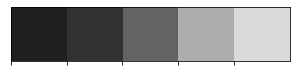

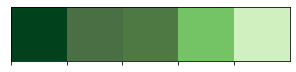

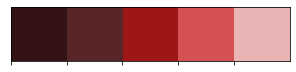

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

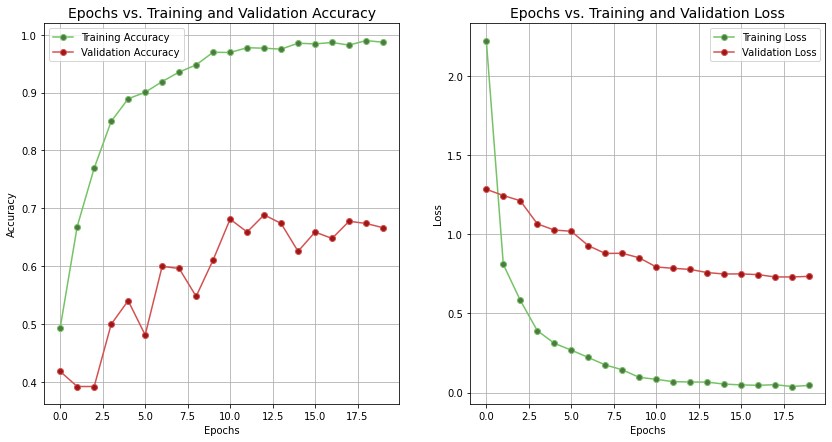

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1, 2, figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Accuracy')
ax[0].legend(frameon=True)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title("Epochs vs. Training and Validation Accuracy", size=14)
ax[0].grid()

ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=True)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].grid()

ax[1].set_title("Epochs vs. Training and Validation Loss", size=14)

plt.savefig("plot_task_B_CNN_no_datagen.jpg", dpi=150)
fig.show()

# Evaluation

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose=0)
val_score = model.evaluate(X_val, y_val, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
print("Training score: ", train_score[1])
print("Validation score: ", val_score[1])
print("Test score: ", test_score[1])

Training score:  0.7069959044456482
Validation score:  0.6666666865348816
Test score:  0.6333333253860474


In [ ]:
pred_train = model.predict(X_train)
pred_train = np.argmax(pred_train, axis=1)
y_train_new = np.argmax(y_train, axis=1)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=1)
y_test_new = np.argmax(y_test, axis=1)

pred_val = model.predict(X_val)
pred_val = np.argmax(pred_val, axis=1)
y_val_new = np.argmax(y_val, axis=1)

In [ ]:
def display_metric_results_A(training_labels, training_predictions, val_labels, val_predictions, test_labels, test_predictions):
    print(f"{'Training Set Accuracy Score:':<31}{accuracy_score(training_labels, training_predictions):>10.4f}")
    print(f"{'Validation Set Accuracy Score:':<31}{accuracy_score(val_labels, val_predictions):>10.4f}")
    print(f"{'Validation Set Precision Score:':<31}{precision_score(val_labels, val_predictions):>10.4f}")
    print(f"{'Validation Set Recall Score:':<31}{recall_score(val_labels, val_predictions):>10.4f}")
    print(f"{'Validation Set F1 Score:':<31}{f1_score(val_labels, val_predictions):>10.4f}")
    print(f"{'Test Set Accuracy Score:':<31}{accuracy_score(test_labels, test_predictions):>10.4f}")
    print(f"{'Test Set Precision Score:':<31}{precision_score(test_labels, test_predictions):>10.4f}")
    print(f"{'Test Set Recall Score:':<31}{recall_score(test_labels, test_predictions):>10.4f}")
    print(f"{'Test Set F1 Score:':<31}{f1_score(test_labels, test_predictions):>10.4f}")

def display_metric_results_B(training_labels, training_predictions, val_labels, val_predictions, test_labels, test_predictions):
    print(f"{'Training Set Accuracy Score:':<31}{accuracy_score(training_labels, training_predictions):>10.4f}")
    print(f"{'Validation Set Accuracy Score:':<31}{accuracy_score(val_labels, val_predictions):>10.4f}")
    print(f"{'Validation Set Precision Score:':<31}{precision_score(val_labels, val_predictions, average='micro'):>10.4f}")
    print(f"{'Validation Set Recall Score:':<31}{recall_score(val_labels, val_predictions, average='micro'):>10.4f}")
    print(f"{'Validation Set F1 Score:':<31}{f1_score(val_labels, val_predictions, average='micro'):>10.4f}")
    print(f"{'Test Set Accuracy Score:':<31}{accuracy_score(test_labels, test_predictions):>10.4f}")
    print(f"{'Test Set Precision Score:':<31}{precision_score(test_labels, test_predictions, average='micro'):>10.4f}")
    print(f"{'Test Set Recall Score:':<31}{recall_score(test_labels, test_predictions, average='micro'):>10.4f}")
    print(f"{'Test Set F1 Score:':<31}{f1_score(test_labels, test_predictions, average='micro'):>10.4f}")

# Task A
display_metric_results_A(y_train_new, pred_train, y_val_new, pred_val, y_test_new, pred_test)

# Task B
# display_metric_results_B(y_train_new, pred_train, y_val_new, pred_val, y_test_new, pred_test)

Training Set Accuracy Score:       0.7070
Validation Set Accuracy Score:     0.6667
Validation Set Precision Score:    0.6667
Validation Set Recall Score:       0.6667
Validation Set F1 Score:           0.6667
Test Set Accuracy Score:           0.6333
Test Set Precision Score:          0.6333
Test Set Recall Score:             0.6333
Test Set F1 Score:                 0.6333
